In [104]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from enum import Enum

In [162]:
#Event = namedtuple('Event', 'person, clique')

class Seir(Enum):
    S = 1
    E = 2
    I = 3
    R = 4


class Person:
    """Class representing a person who is part of one or more cliques."""
        
    def __init__(self, id, starting_clique, num_cliques, switching_frequency, initial_infection_rate):
        self.id = id
        self.clique_seq = []
        self.clique_seq.append(starting_clique)
        self.num_cliques = num_cliques
        self.switching_frequency = switching_frequency * num_cliques / (num_cliques - 1)
        if np.random.rand() < initial_infection_rate:
            self.state = Seir.E
            print('Person {} initially exposed'.format(id))
        else:
            self.state = Seir.S


    def simulate_behavior(self, time_steps):
        curr_clique = self.clique_seq[-1]
        for i in range(time_steps):
            if np.random.rand() < self.switching_frequency:
                self.clique_seq.append(np.random.randint(self.num_cliques))
            else:
                self.clique_seq.append(curr_clique)
            curr_clique = self.clique_seq[-1]



In [163]:
CLIQUE_COLORS = {
    'S': 'g',
    'E': 'y',
    'I': 'r',
    'R': 'k',
}

def display_clique(id, clique):
    x_coord = int(id / 14)
    y_coord = id % 14
    for i in range(len(clique)):
        x_offset = int(i / 3)
        y_offset = i % 3
        plt.scatter(x_coord + x_offset / 10, y_coord + y_offset / 10, c=CLIQUE_COLORS[clique[i].state.name])
        

In [167]:
NUM_PEOPLE = 1000
NUM_CLIQUES = 196
TIME_STEPS = 100
INITIAL_INFECTION_RATE = 0.005 # Infection rate
EXPOSED_TIME = 3 # SEIR model means first few days is likely non-infectious
INFECTED_TIME = 5 # days a person remains infectious
SWITCHING_FREQUENCY = 0.03 # 1 / days between a person hopping to a new clique
CHANCE_OF_SPREAD = 0.14 # Depends on facemasks, duration of exposure, and frequency of meetups

# Monte Carlo Simulation

Randomly give people covid based on their risk profiles. Randomly simulate exposure time and recovery time.

Person 13 initially exposed
Person 88 initially exposed
Person 181 initially exposed
Person 463 initially exposed
Person 569 initially exposed
Person 688 initially exposed
Person 933 initially exposed


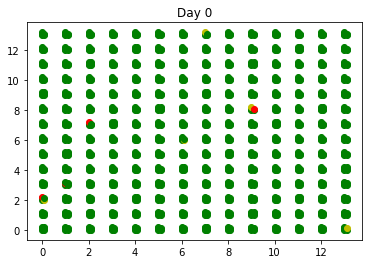

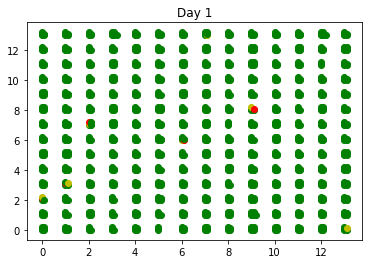

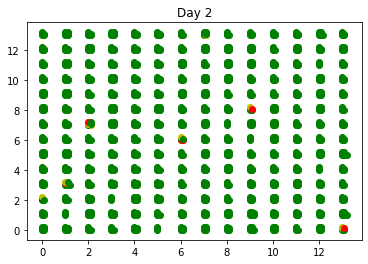

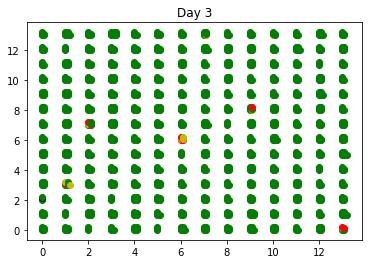

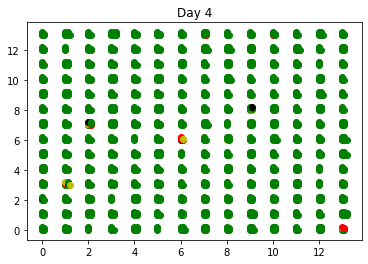

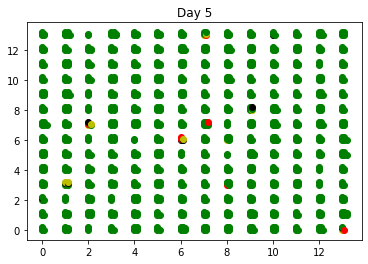

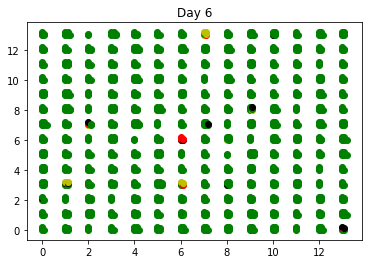

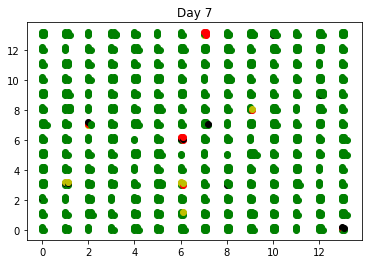

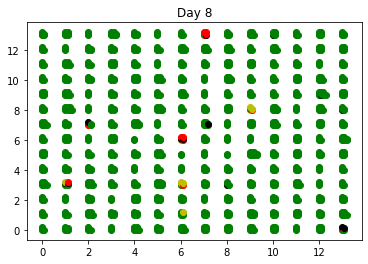

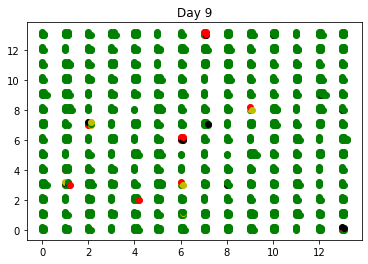

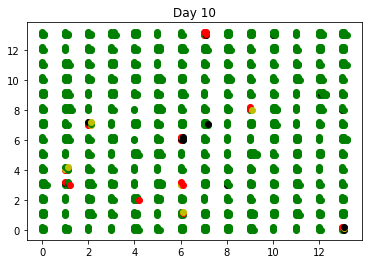

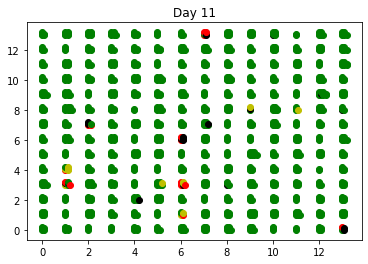

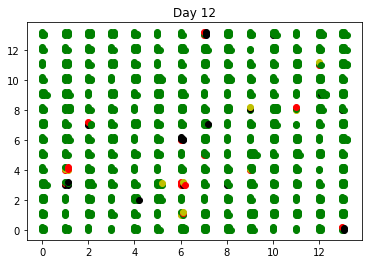

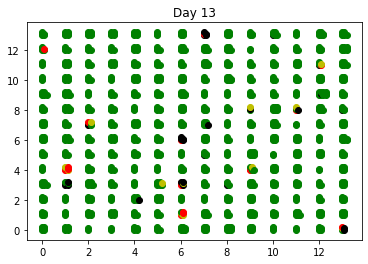

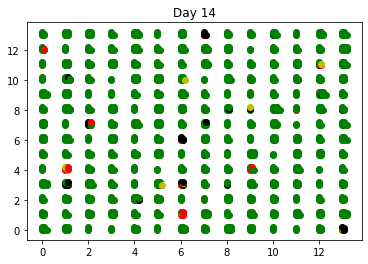

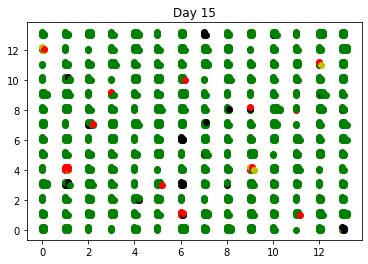

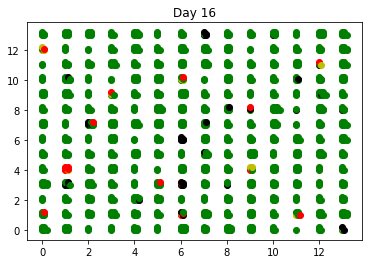

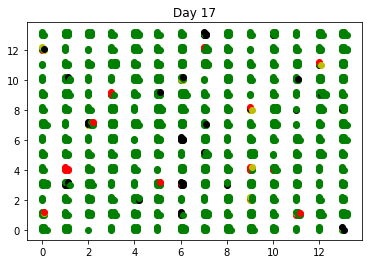

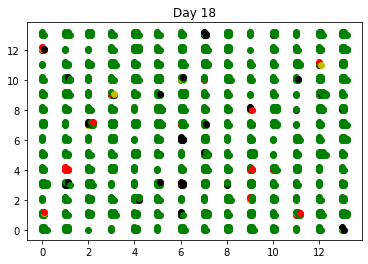

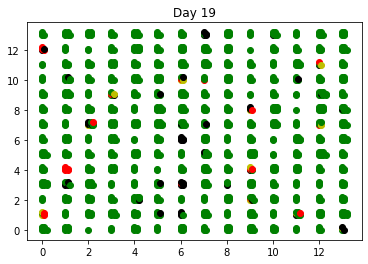

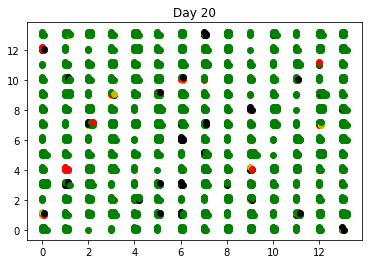

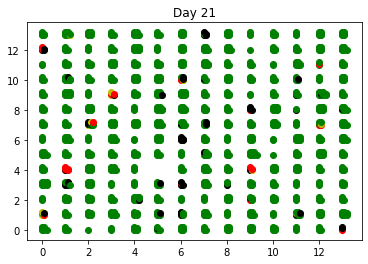

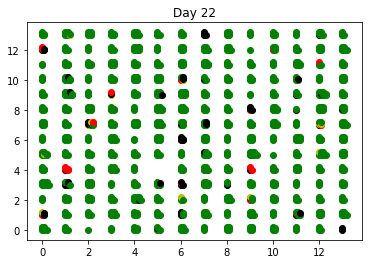

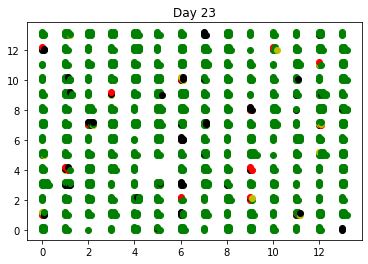

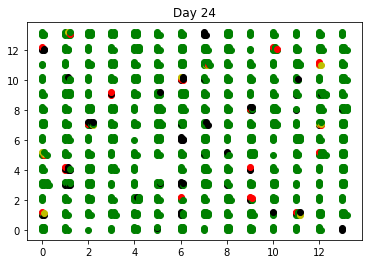

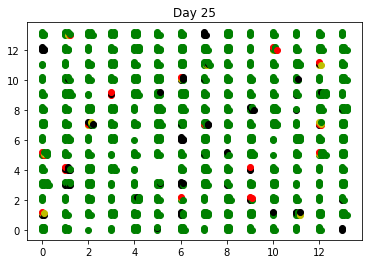

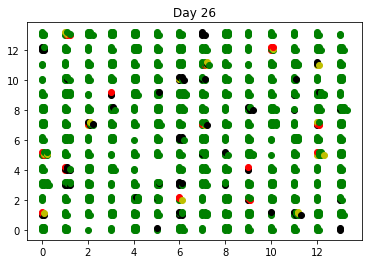

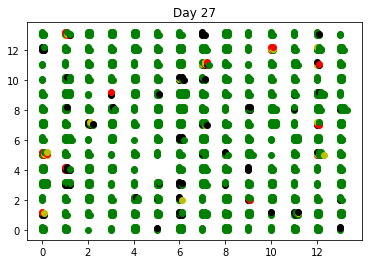

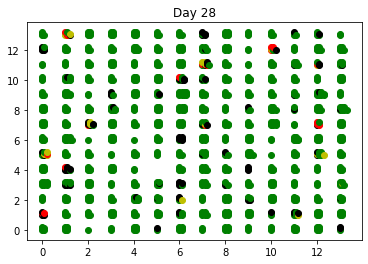

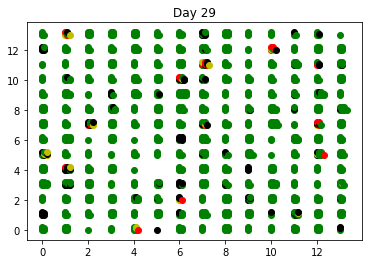

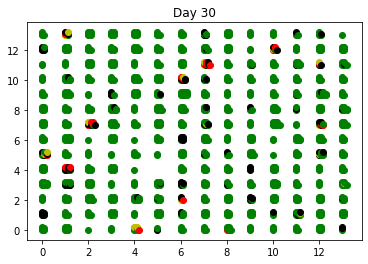

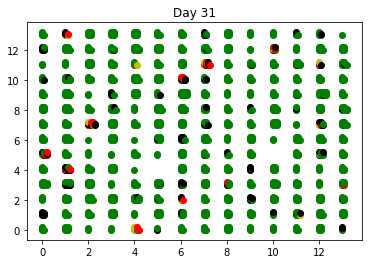

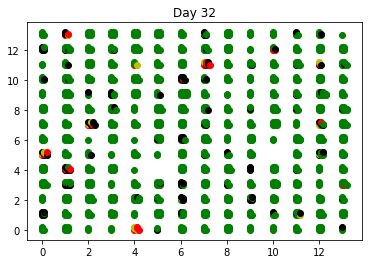

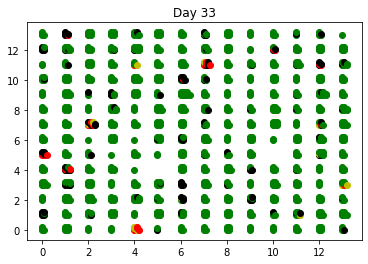

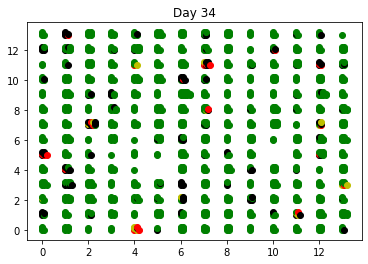

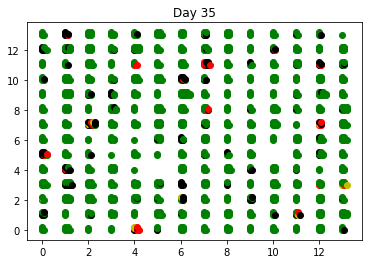

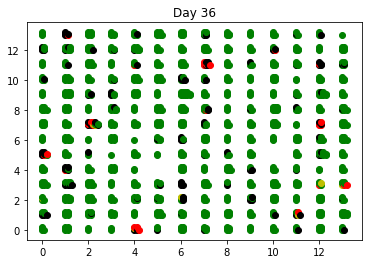

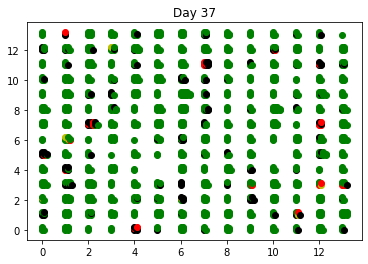

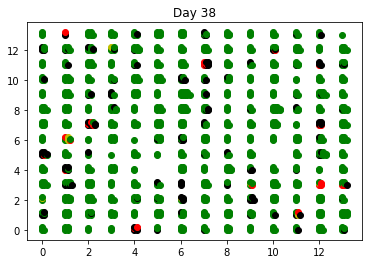

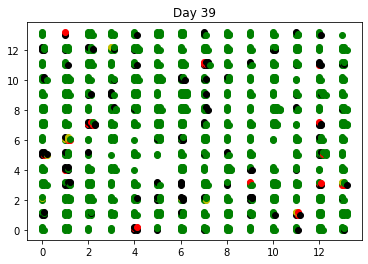

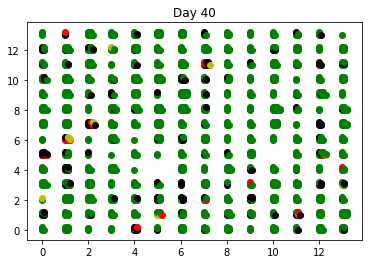

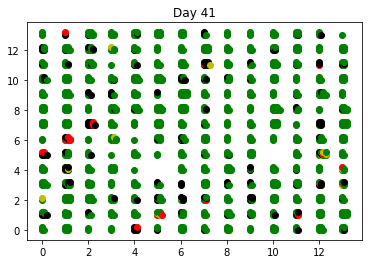

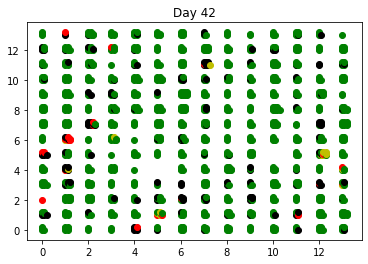

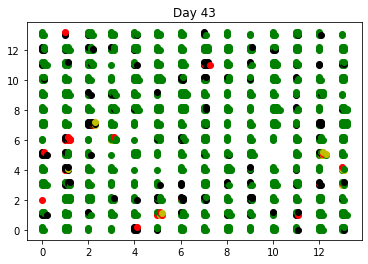

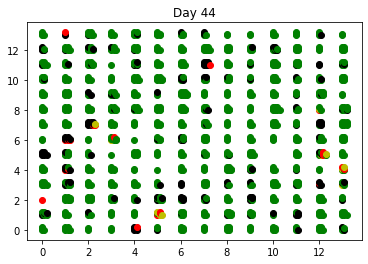

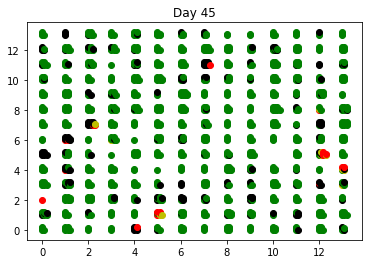

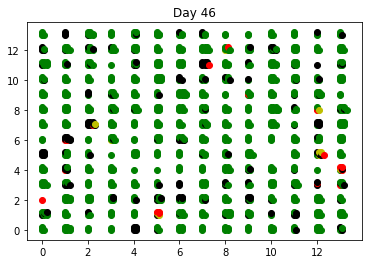

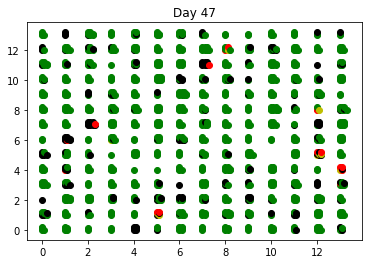

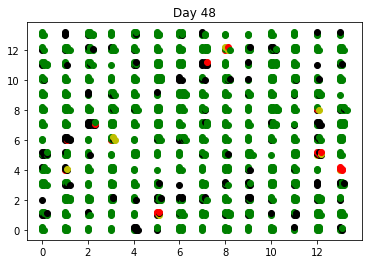

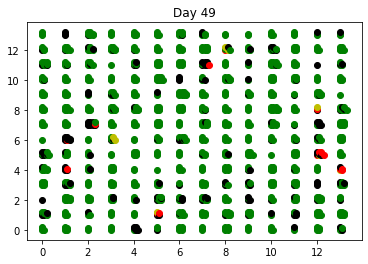

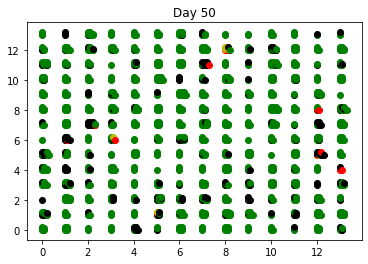

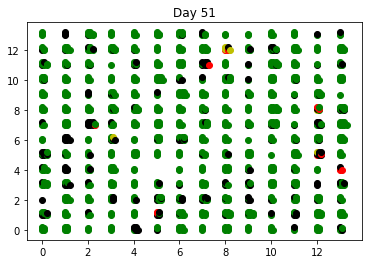

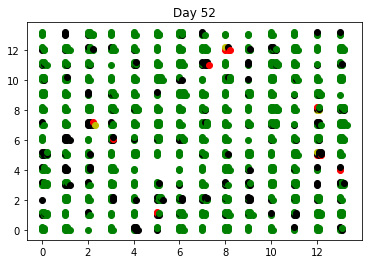

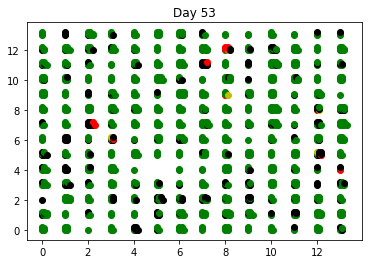

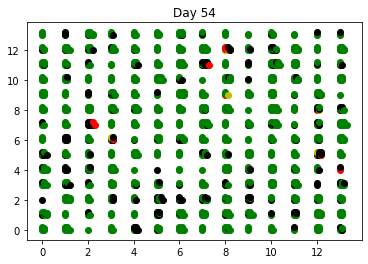

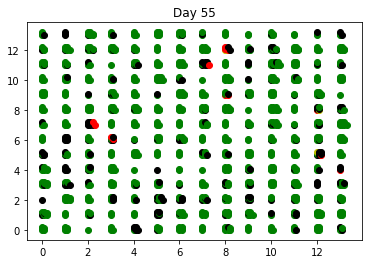

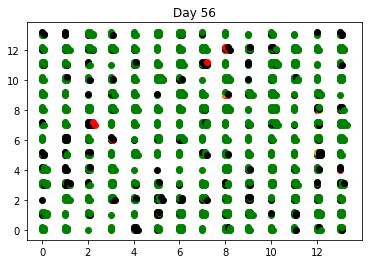

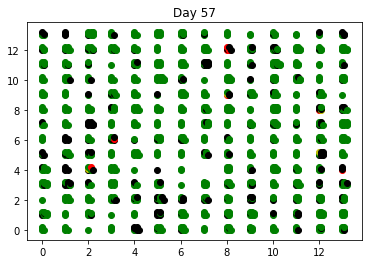

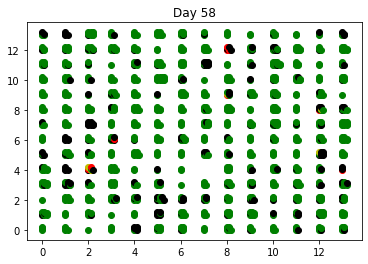

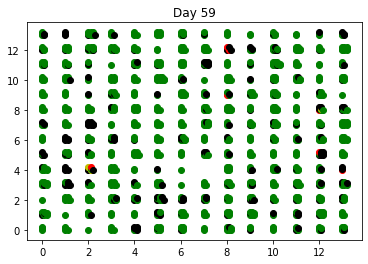

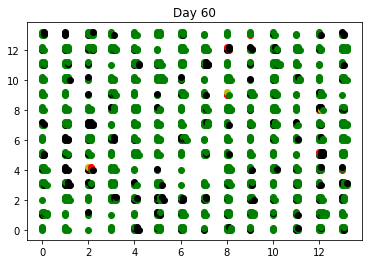

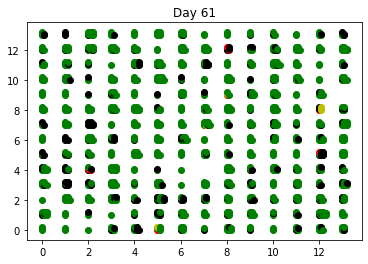

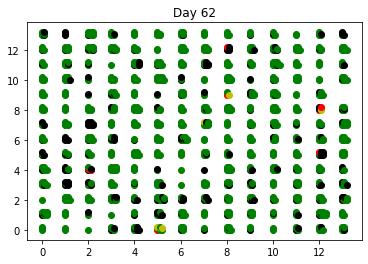

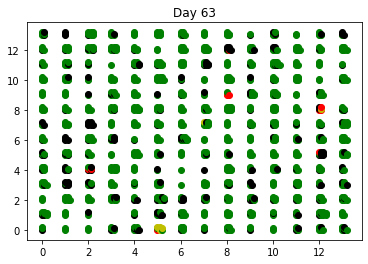

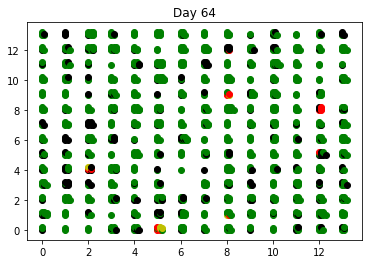

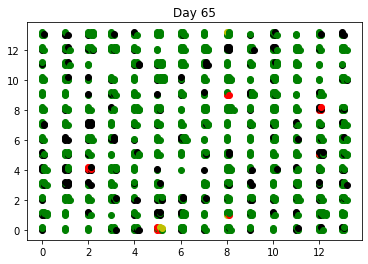

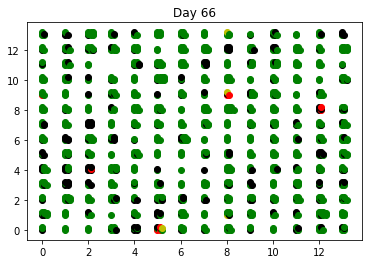

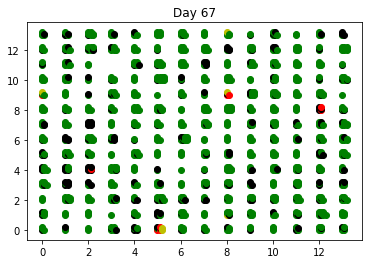

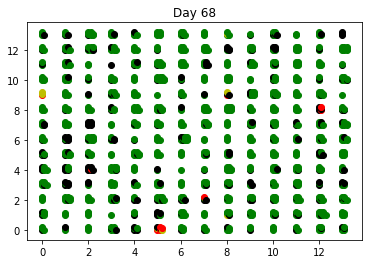

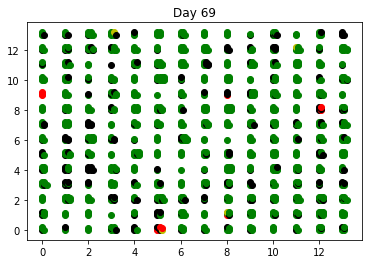

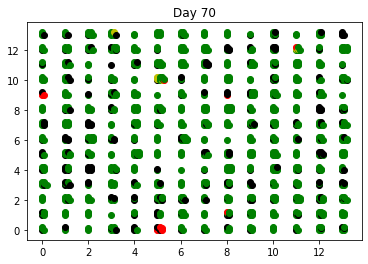

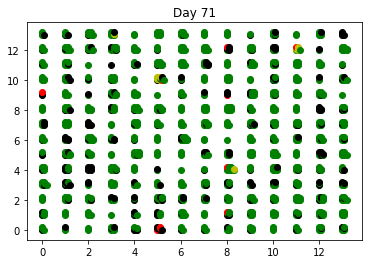

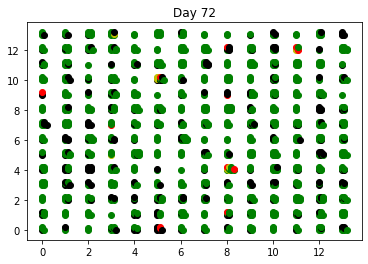

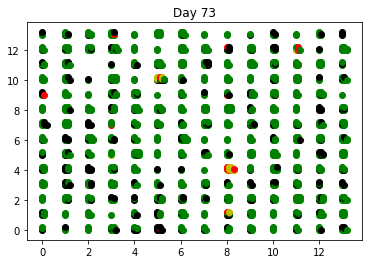

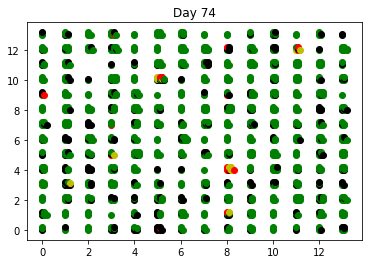

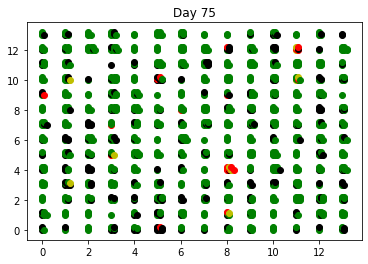

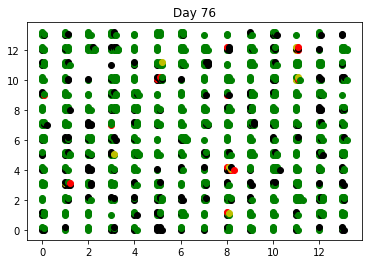

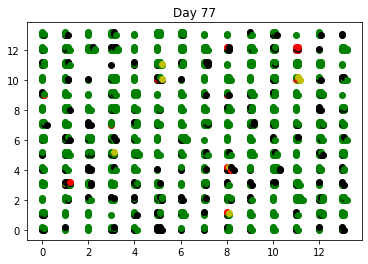

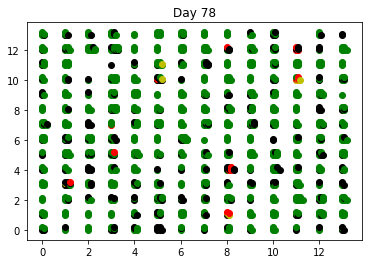

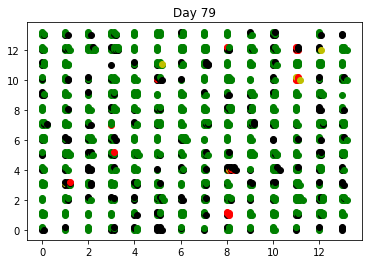

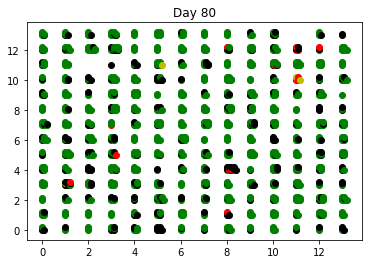

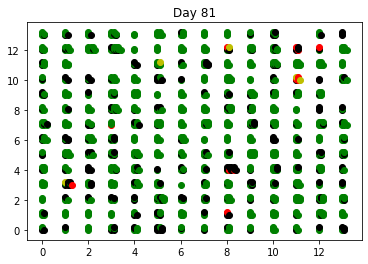

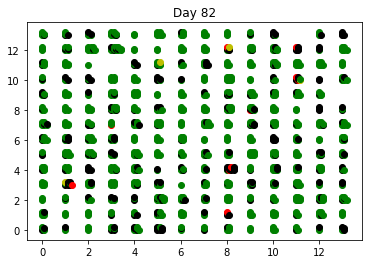

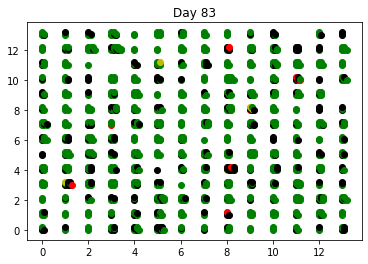

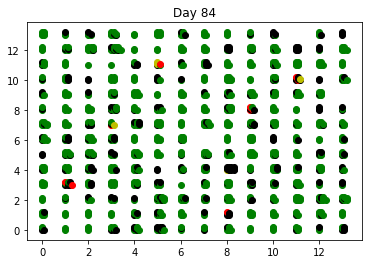

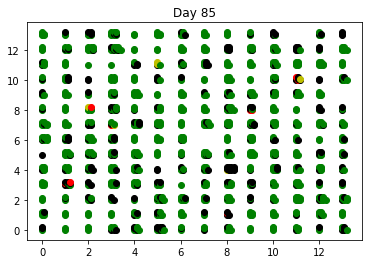

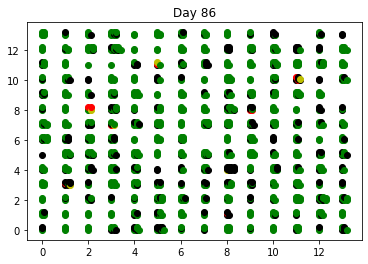

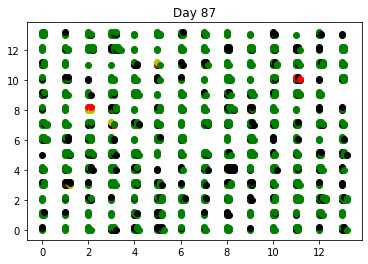

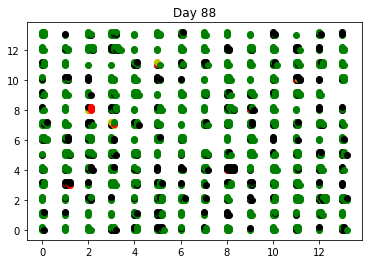

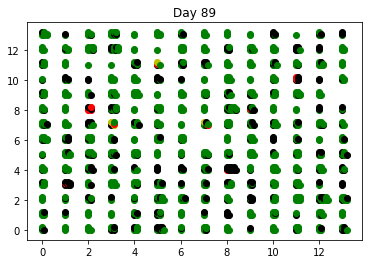

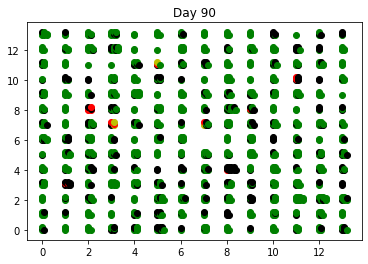

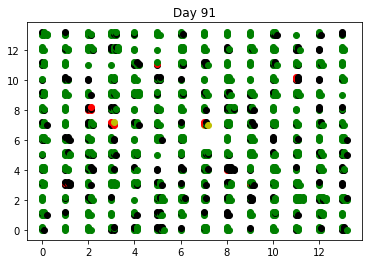

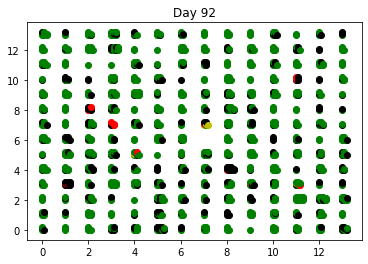

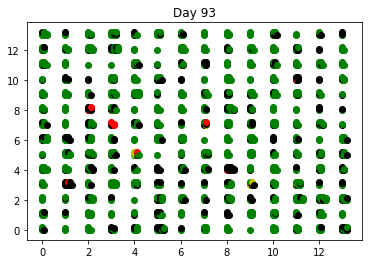

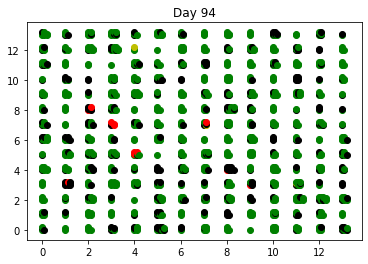

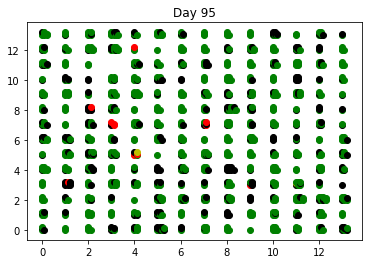

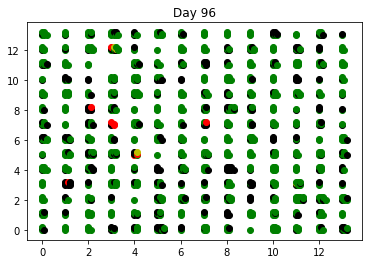

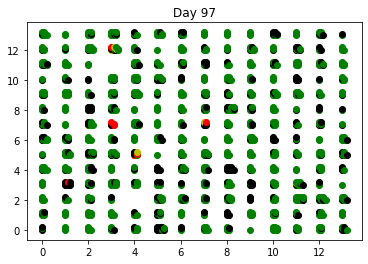

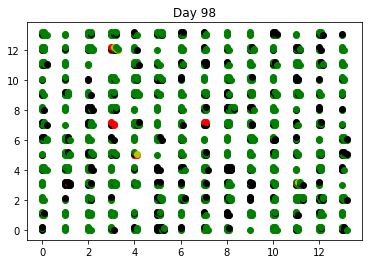

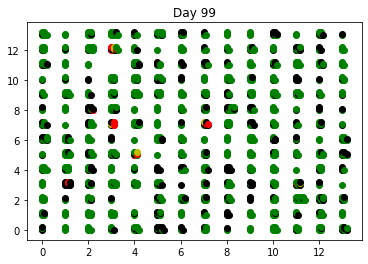

326


In [168]:
DEBUG = False

people = []
for i in range(NUM_PEOPLE):
    people.append(Person(i, int(i * NUM_CLIQUES / NUM_PEOPLE), NUM_CLIQUES, SWITCHING_FREQUENCY,
                        INITIAL_INFECTION_RATE))

for i in range(NUM_PEOPLE):
    people[i].simulate_behavior(TIME_STEPS)
# When you mix, your risks are added with everyone in the group. Your risk to others outside the group are also increased.
for t in range(TIME_STEPS):
    # Add each person to their new clique
    cliques = defaultdict(list)
    for i in range(NUM_PEOPLE):
        # Randomly progress through the SEIR model
        person = people[i]
        randval = np.random.rand()
        if person.state == Seir.E and randval < 1.0 / EXPOSED_TIME:
            person.state = Seir.I
            if DEBUG:
                print('{} is infected at time {}'.format(person.id, t))
        elif person.state == Seir.I and randval < 1.0 / INFECTED_TIME:
            person.state = Seir.R
            if DEBUG:
                print('{} is recovered at time {}'.format(person.id, t))
        cliques[people[i].clique_seq[t]].append(people[i])
    # Aggregate risks for each person to their group
    max_clique_size = 0
    for i in range(NUM_CLIQUES):
        for p_rx in cliques[i]:
            clique_size = len(cliques[i])
            if len(cliques[i]) > max_clique_size:
                max_clique_size = clique_size
            if p_rx.state == Seir.S:
                for p_tx in cliques[i]:
                    if p_tx.state == Seir.I and np.random.rand() < CHANCE_OF_SPREAD:
                        p_rx.state = Seir.E
                        if DEBUG:
                            print('{} exposed {} at time {}'.format(p_tx.id, p_rx.id, t))
        display_clique(i, cliques[i])
    plt.title('Day {}'.format(t))
    plt.savefig('data/images/clique/static{:04d}.png'.format(t))
    plt.show()
    if DEBUG:
        print('Max clique size at time {}: {}'.format(t, max_clique_size))
print(sum([person.state != Seir.S for person in people]))